In [221]:
import imgaug.augmenters as iaa
import cv2
import glob
import PIL
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
from imgaug import augmenters as iaa
import imgaug as ia
import warnings
warnings.filterwarnings(action='ignore')

mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

# Pytorch transform을 활용한 간단한 어그멘테이션

- imgaug를 활용하지 않고 Pytorch로만 어그멘테이션 진행하는 방법임

In [222]:
def show_dataset(dataset, n=6):
  # np.hstack을 통해 하나의 row에 6개의 이미지를 이어붙임(horizontal 방향)
  # np.vstack을 통해 여러개의 row를 이어붙임(vertical 방향)
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

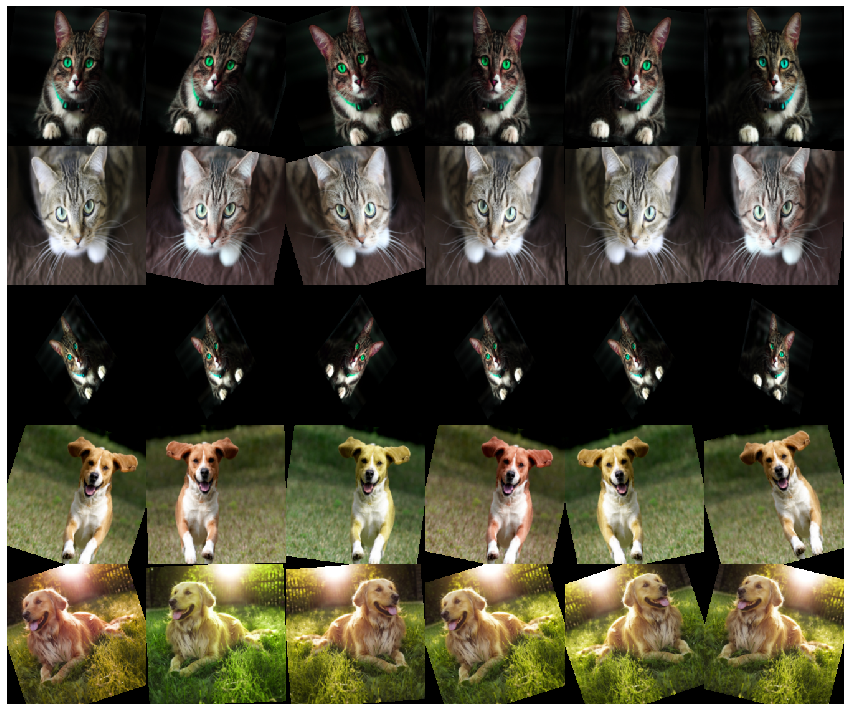

In [223]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

dataset = torchvision.datasets.ImageFolder('./data/', transform=transforms)

show_dataset(dataset)

# Imgaug, Pytorch 결합해서 사용

- 첫번째 방법: ImgAugTransform이라는 클래스를 만들어서 호출 가능하게 구현 (`__call__ 활용`) 한 뒤 `torchvision.datasets` 객체의 `transform` 인자로 넘김

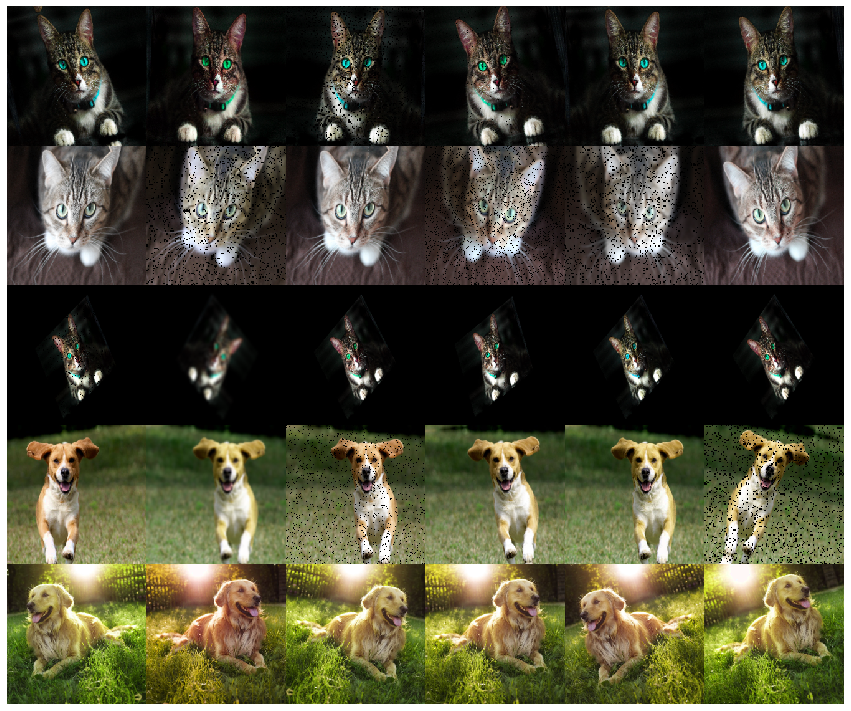

In [224]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms = ImgAugTransform()

dataset = torchvision.datasets.ImageFolder('./data/', transform=transforms)

show_dataset(dataset)

- 두번째 방법: `torchvision.transforms.Compose`의 일부분으로 imgaug 라이브러리를 활용할 수 있음

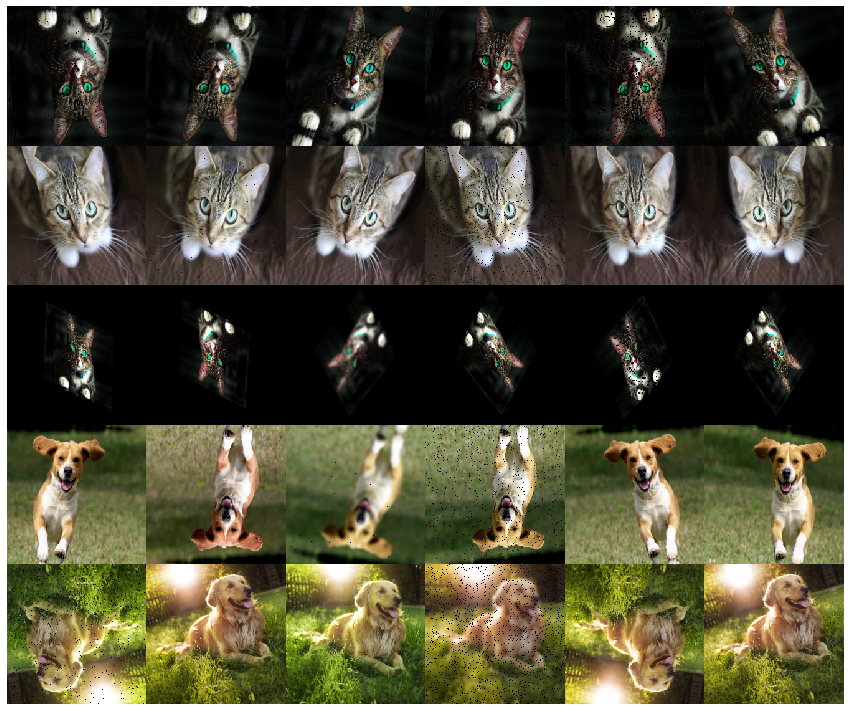

In [225]:
transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),       # show_dataset 에서 이미지 출력하려면 PIL 형태로 변환해줘야함
    torchvision.transforms.RandomVerticalFlip()     # torchvision.transforms는 PIL 객체도 변환해줌
])

dataset = torchvision.datasets.ImageFolder('./data/', transform=transforms)

show_dataset(dataset)

## 여러 이미지 어그멘테이션

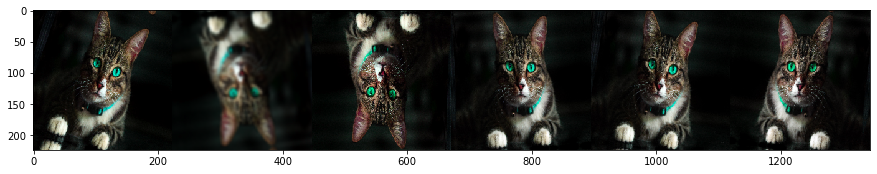

In [226]:
aug = iaa.Affine(rotate=(-40, 40), mode='symmetric')
imgs = [np.asarray(dataset[0][0]) for _ in range(6)]        # 고양이 이미지 6개 담고 있는 imgs 리스트
aug.augment_images(imgs)
plt.imshow(np.hstack(imgs))     # column-wise하게 이미지를 펼쳐서 한번에 보여주기 위함

## Yolo format bbox augmentation

- 아래 코드는 다음과 같은 목적으로 만들어짐
  - Yolov5 학습을 위해 커스텀 데이터를 구축하여 레이블링 작업까지 마친 데이터로 어그멘테이션을 하고싶음
  - 코드 실행하면 어노테이션된 이미지, txt 파일이 추출되게 하여 바로 학습에 사용하고 싶음

In [219]:
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def yoloToPIL(img_path, label_path):
    coor_list = []
    img = PIL.Image.open(img_path)
    img = np.array(img)     # height, width, channel
    img_height, img_width = img.shape[0], img.shape[1]

    with open(label_path) as f:
        data = f.readlines()
    
    coor_list = []

    # 여러 bounding box 정보를 담기 위함
    for idx, bbox in enumerate(data):
        cls, cx, cy, norm_width, norm_height = map(float, bbox.split())
        
        print(f"{idx} 번째 BBOX 정보: {cx, cy, norm_width, norm_height}")

        # PIL에 맞게 스케일링
        _x1, _y1, _x2, _y2 = (cx - norm_width/2), (cy - norm_height/2), (cx + norm_width/2), (cy + norm_height/2)
        print(f"_x1: {_x1}")
        _x1 *= img_width
        _x2 *= img_width
        _y1 *= img_height
        _y2 *= img_height

        coor_list.append([cls, _x1, _y1, _x2, _y2, norm_width, norm_height])    # norm_width, norm_height는 좌표 복원할 때 쓰임    
                                                                                # norm 붙인 이유는 0 ~ 1 까지 범위로 스케일링 되어있기 때문

    # 리스트 컴프리헨션 이용하여 여러개의 box 있는 경우 다 그림
    bbs = BoundingBoxesOnImage([
    BoundingBox(x1=_x1, y1=_y1, x2=_x2, y2=_y2) for _, _x1, _y1, _x2, _y2, _, _ in coor_list
    ], shape=img.shape)

    # 어그멘테이션 코드
    seq = iaa.Sequential([
        iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
        iaa.Affine(
            translate_px={"x": 40, "y": 60},
            scale=(0.5, 0.7),
            shear=(30, 17)
        ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
    ])

    # Augment BBs and images.
    # bbs_aug 변수를 활용하여 어그멘테이션 이후의 cx, cy, width, height 추출 가능
    image_aug, bbs_aug = seq(image=img, bounding_boxes=bbs)

    # image with BBs before/after augmentation (shown below)
    image_before = bbs.draw_on_image(image, size=10)
    image_after = bbs_aug.draw_on_image(image_aug, size=10, color=[0, 0, 255])

    # yolo 포맷으로 어그멘테이션 된 img, txt 파일 저장
    img = PIL.Image.fromarray(image_aug)
    img.save('./data/cats/aug.jpg')

    img_height, img_width = img.height, img.width

    annotation = []

    for idx,bbox in enumerate(bbs_aug):
        # cls, norm_width, norm_height = int(coor_list[idx][0]), img_width, img_height
        cls = int(coor_list[idx][0])
        _x1, _y1, _x2, _y2 = bbox.x1, bbox.y1, bbox.x2, bbox.y2

        # augmentation 된 이미지에서 bbox 포인트 0~1로 normalization
        _x1 /= img_width
        _x2 /= img_width
        _y1 /= img_height
        _y2 /= img_height

        # normalization된 bbox 포인트 이용해서 normalization된 width, height 추출
        norm_width = _x2 - _x1      
        norm_height = _y2 - _y1

        print(norm_width, norm_height)
        cx, cy = (_x1 + norm_width/2), (_y1 + norm_height/2)

        # annotation 리스트에 텍스트 파일로 저장할 정보 저장
        annotation.append(f'{cls} {cx} {cy} {norm_width} {norm_height}\n')

    # 텍스트 파일 작성
    with open('./data/cats/aug.txt', 'w') as f:
        for idx, row in enumerate(annotation):
            # print(f"재현된 {idx} 번째 BBOX: {row}")
            f.write(row)

In [220]:
LABEL_PATH = './data/cats/adorable-animal-blur-617278.txt'
IMAGE_PATH = './data/cats/adorable-animal-blur-617278.jpg'
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

coor_list = yoloToPIL(IMAGE_PATH, LABEL_PATH)

0 번째 BBOX 정보: (0.477577, 0.502145, 0.601258, 0.985294)
_x1: 0.176948
1 번째 BBOX 정보: (0.477577, 0.502145, 0.491258, 0.885294)
_x1: 0.231948
bbx 정보: BoundingBoxesOnImage([BoundingBox(x1=871.9997, y1=31.0015, x2=3834.9992, y2=3247.0011, label=None), BoundingBox(x1=1143.0397, y1=194.2015, x2=3563.9592, y2=3083.8011, label=None)], shape=(3264, 4928, 3))
0.4162601124156606 0.7356426482107126
0.3547834173425452 0.6429340886134727
재현된 0 번째 BBOX: 0 0.4989208122352501 0.5112393837349087 0.4162601124156606 0.7356426482107126

재현된 1 번째 BBOX: 0 0.4989208246206308 0.5112394071092792 0.3547834173425452 0.6429340886134727



# BBOX Imgaug 예시

BB 0: (50.0000, 0.0000, 200.0000, 150.0000) -> (46.6994, 128.0000, 230.6013, 128.0000)


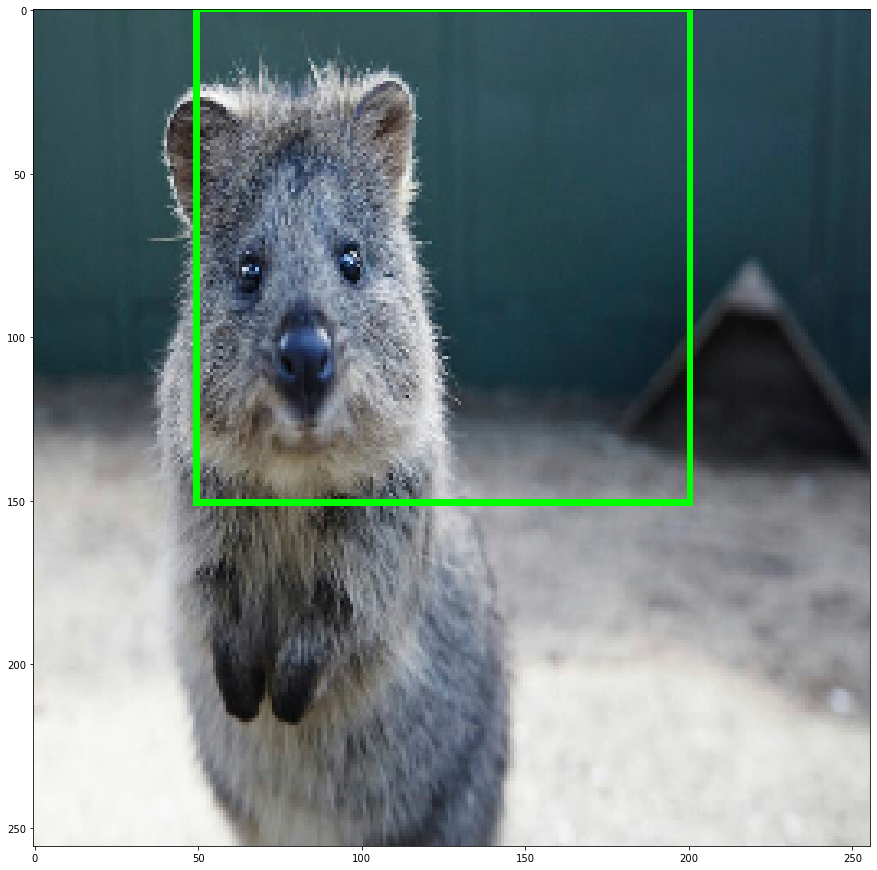

In [211]:
image = ia.quokka(size=(256, 256))
bbs = BoundingBoxesOnImage([
    BoundingBox(x1=50, y1=0, x2=200, y2=150),
    # BoundingBox(x1=150, y1=80, x2=200, y2=130)
], shape=image.shape)

seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ), # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
    iaa.ShearX(90),
])

# Augment BBs and images.
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(image, size=2)
image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

plt.imshow(image_before)

In [212]:
# _x1, _y1, _x2, _y2 = (cx - width/2), (cy - height/2), (cx + width/2), (cy + height/2)
# _x1 *= img_width

width = 0.601258
img_width = 4928

cx = 0.477577

_x1 = cx - width / 2
_x1 *= img_width

print(_x1)

_x1 /= img_width
cx = _x1 + width / 2

print(cx)

871.999744
0.477577


In [1]:
list([640, 480])

[640, 480]

In [3]:
list('[640, 480]')

['[', '6', '4', '0', ',', ' ', '4', '8', '0', ']']